# The Direct linear transform (DLT)

Direct Solution for Computing Fundamental (for uncalibrated camera) and Essential (for calibrated camera) Matrix.

The Fundamental and Essential Matrices contain all information about the relative orientation (of two cameras) that can be extracted from corresponding image points.

### Our aim is to derive the relative pose of camera $C_2$ w.r.t. $C_1$.

To achieve this we use the coplanarity constraint: 
$${x'_n}^T F {x''_n}^T = 0$$
where $x'_n$ and $x''_n$ are corresponding image points in image 1 and image 2 respectively. (This constraint comes from the epipolar geometry.)


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

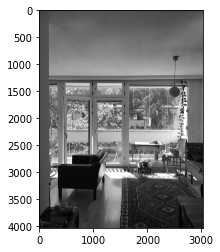

In [5]:
# Loading images. 
basename = "livingroom"
cam_1_path = "./img/" + basename + "_l" + ".JPG"
cam_2_path = "./img/" + basename + "_r" + ".JPG"

img1 = cv2.imread(cam_1_path, 0)
img2 = cv2.imread(cam_2_path, 0)

plt.imshow(img1, cmap="gray")


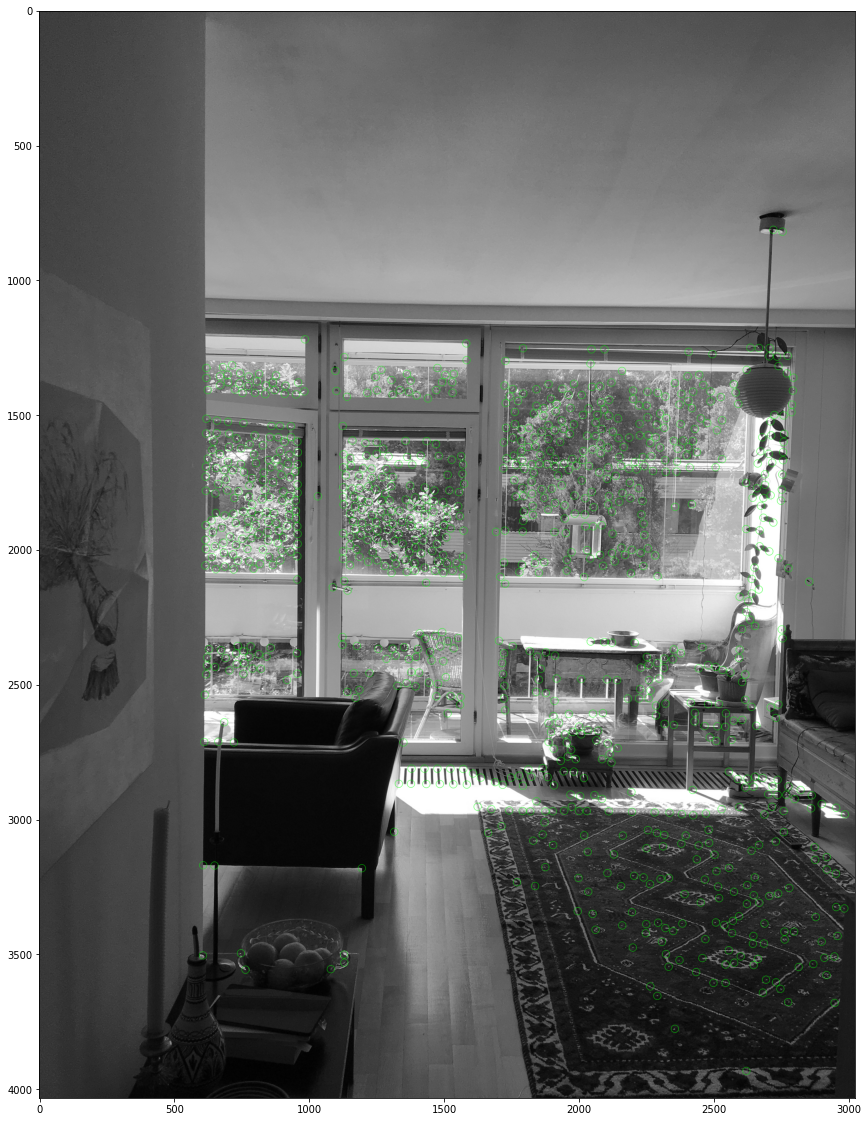

In [6]:
# Extracting features from images.
orb = cv2.ORB_create()

""" kp1 = orb.detect(img_1, None)
kp2 = orb.detect(img_2, None) """

pts1 = cv2.goodFeaturesToTrack(img1, 1000, qualityLevel=0.1, minDistance=28)
pts2 = cv2.goodFeaturesToTrack(img2, 1000, qualityLevel=0.1, minDistance=28)

kp1 = [cv2.KeyPoint(x=p[0][0], y=p[0][1], _size = 28) for p in pts1]
kp2 = [cv2.KeyPoint(x=p[0][0], y=p[0][1], _size = 28) for p in pts2]

# Compute descriptions for extracted features.
kp1, des1 = orb.compute(img1, kp1)
kp2, des2 = orb.compute(img2, kp2)


img_with_keypoints = cv2.drawKeypoints(img2, kp2, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(20, 20))
plt.imshow(img_with_keypoints)


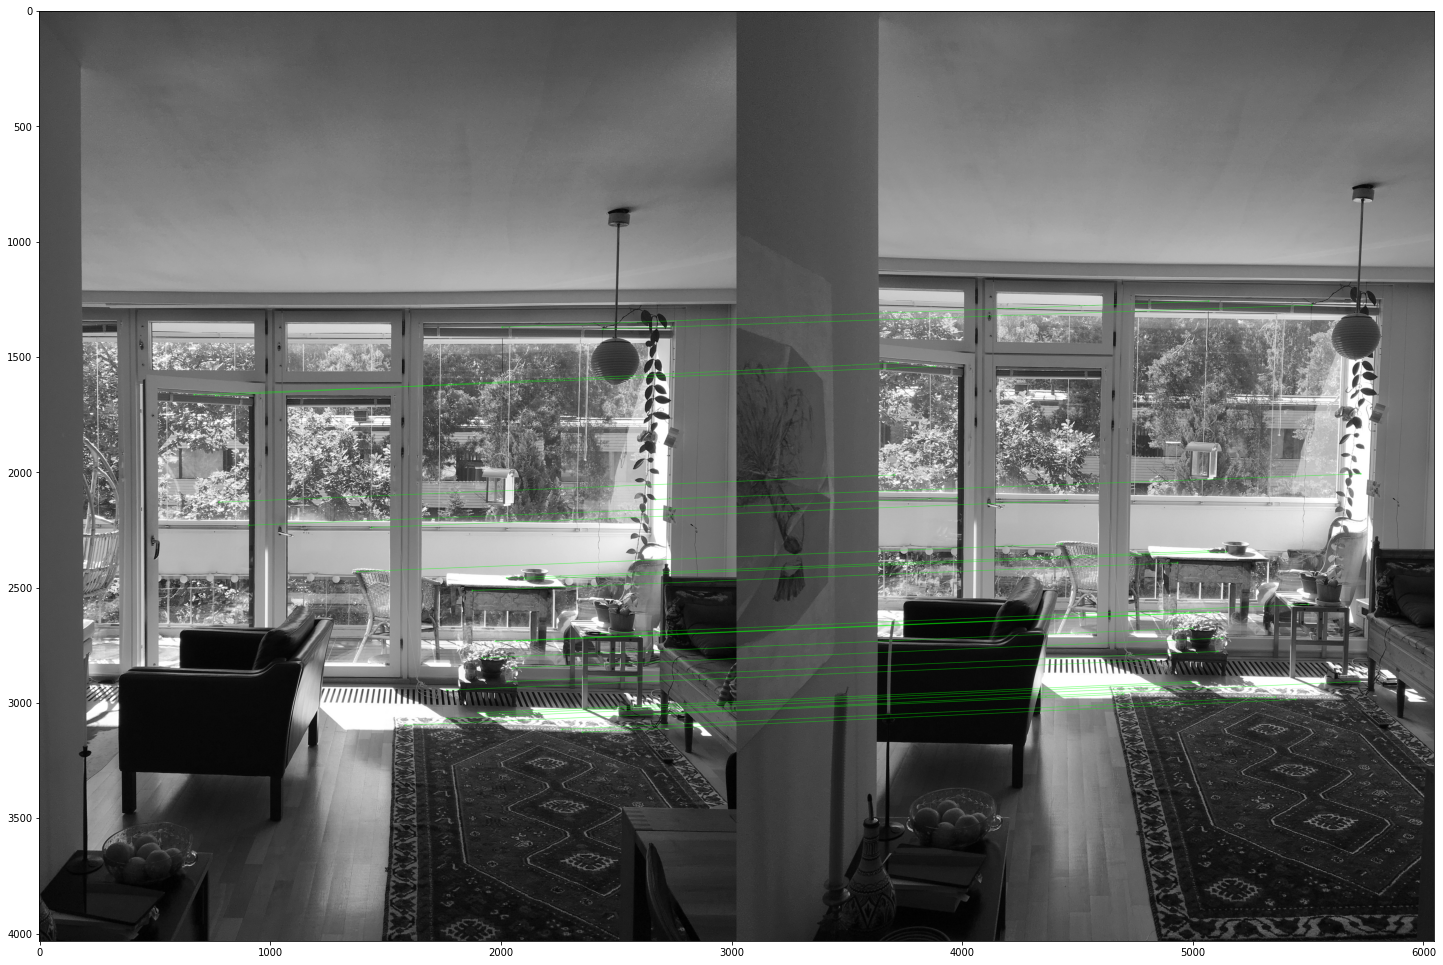

In [7]:
# Matching features to obtain point correspondences.

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

matches = sorted(matches, key = lambda x:x.distance)

matches_img = cv2.drawMatches(img1, kp1, img2, kp2, matches[:(len(matches)//10)],None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS, matchColor=(0, 255, 0))
plt.figure(figsize=(25, 25))
plt.imshow(matches_img)

### The constraints
Now that we have our matching image points we can start to solve for F. We can reshape the epipolar constraint in to the form $a_n^T f = 0$, where $f$ and $a_n$ are $9 \times 1$ vectors. $f$ is the reshaped form of $F$ (in a row major order) and $a_n = x'_n \otimes x''_n$, where $\otimes$ is the kronecker product.

Let us construct a linear system of equations:
$ A f = 0 $ where $A$ is a $m \times 9$ matrix with its rows consisting of $a_n$. In order for the equation to have a solution, $A$ must be at most of rank 8. Assuming that our "match vectors" $a_n$ are independent (not too close to each other), we get a suitable $A$ matrix candidate by stacking 8 of such "match vectors" transposed on top of each other. 

Note that f will be fixed only up to scale (as the nullspace of $A$ contains infinitely many points). This is ok as f is a Homogeneus matrix.

##### Handling errors in the detection and matching process.
Our matches will have errors and the feature detection will not be perfectly accurate. We can employ different schemes to deal with this.
*   One option is to use a RANSAC approach.
*   We could also make the matrix taller and obtain f from the 9:th singular vector corresponding to the singular value of 0.

#TBC...